## dataset path

In [1]:
input_path = 'input/'
model_path = 'output/'
model_path = 'model_checkpoint/ae.pth'

## imports

In [33]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import os
import glob
import numpy as np
from cv2 import cv2
import albumentations as albu
from torch.utils.data import ConcatDataset

import segmentation_models_pytorch as smp
import torch
import torch.nn as nn

## utils functions

In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

## pytorch dataset

## augmentations and smp preprocess

In [4]:
import albumentations as albu

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(256, 256, always_apply=True, border_mode=cv2.BORDER_CONSTANT, value=0)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing_no_pretrain():
    """Construct preprocessing transform
    
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [5]:
class Dataset(BaseDataset):
    """
    Args:
        images_path (str): path of input dir
        clahe (bool): do clahe or not
        do_resize (tuple of ints): resize the image and mask, if None, DO NOT do resize
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self,
            images_path,
            clahe = False,
            do_resize = (256, 256),
            augmentation=get_validation_augmentation(), 
            preprocessing=get_preprocessing_no_pretrain(),
    ):
        self.images_path = images_path 
        self.images = glob.glob(os.path.join(images_path, '*'))

        # check if do augmentation and preprocess
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        self.do_resize = do_resize
        self.clahe = clahe
    
    def __getitem__(self, i):

        # read img
        image = cv2.imread(self.images[i], 0) # read  GRAY

        if self.clahe:
            # create a CLAHE object (Arguments are optional).
            clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
            image = clahe.apply(image)

        if self.do_resize:
            image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']
        
        # get origin image before normalization
        ori = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

        # image channel
        image = np.expand_dims(image, axis=-1)
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']
            image = image/255

            
        return image, ori
        
    def __len__(self):
        return len(self.images)


## Define VAE

https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb

In [6]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [7]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [8]:
class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(256, h_dim, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 256, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, image_channels, kernel_size=4, stride=2),
            nn.AdaptiveAvgPool2d((256, 256)),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(DEVICE)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

# if __main__

### define model

In [9]:
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = 'cuda:0'

model = VAE(image_channels=1).to(DEVICE)

In [10]:
model.load_state_dict(torch.load(model_path, map_location=DEVICE))

<All keys matched successfully>

### get dataset instances

In [11]:
dataset = Dataset(input_path)

In [12]:
len(dataset)

7

## let's take a look at data distribtion

in theory, ap/pa and lateral should have different distribution in latent space

In [37]:
classes = [] # 0 for ap/pa, 1 for lateral
collect_u = []
collect_var = []
collect_rerr = []

In [38]:
for i in range(len(dataset)):
    # load data
    image, _ = dataset[i]

    # check class name
    if 'ap' in dataset.images[i]:
        classes.append(0)
    elif 'lateral' in dataset.images[i]:
        classes.append(1)

    # feed to VAE
    # convert image to tensor
    x_in = torch.tensor(image).unsqueeze(0).to(DEVICE)

    # start fiting image to network
    with torch.no_grad():
        out = model(x_in)

    # get output 
    x_out = out[0].cpu() # output image
    u = np.mean(out[1].cpu().numpy()) # mean u
    var = np.mean(out[2].cpu().numpy()) # mean var
    err = np.sum(image.squeeze() - x_out.numpy().squeeze()) # reconstruction error

    collect_u.append(u)
    collect_var.append(var)
    collect_rerr.append(err)


### plot distributions

In [62]:
color = ['tab:blue', 'tab:orange']

Text(0, 0.5, 'log var (var)')

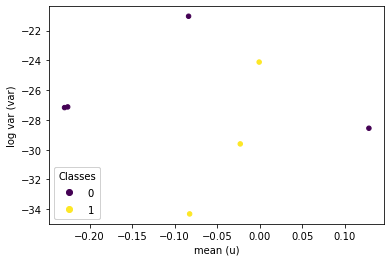

In [76]:
fig, ax = plt.subplots()

scatter = ax.scatter(collect_u, collect_var, s=20, c=classes)

# https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html#automated-legend-creation
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)


ax.set_xlabel('mean (u)')
ax.set_ylabel('log var (var)')

## try some cases

#### lateral

image name
input/lateral1.jpg

image shape
(256, 256, 3)


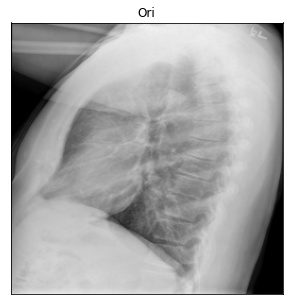

In [13]:
# visualization
image, ori = dataset[0]

print('image name')
print(dataset.images[0])
print()

print('image shape')
print(ori.shape)


# visual data
visualize(
    ori=ori,
)

convert image to tensor
start fiting image to network
get output
reconstructing error is 1208.0731201171875


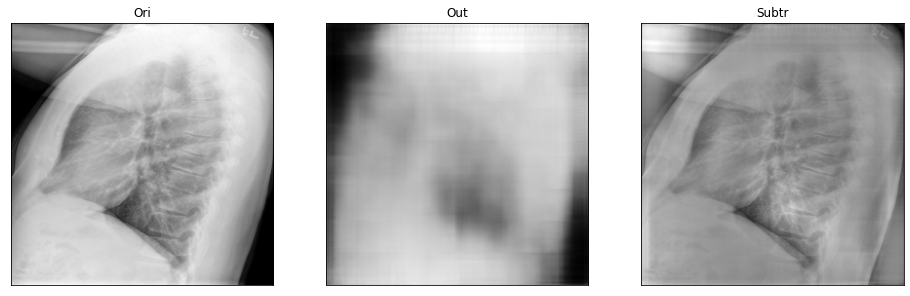

In [14]:
print('convert image to tensor')
x_in = torch.tensor(image).unsqueeze(0).to(DEVICE)

print('start fiting image to network')
with torch.no_grad():
    out = model(x_in)

print('get output')
x_out = out[0].cpu()


print('reconstructing error is {}'.format(np.sum(image.squeeze() - x_out.numpy().squeeze())))

# visual data
visualize(
    ori=image.squeeze(),
    out=x_out.numpy().squeeze(),
    
    subtr = image.squeeze() - x_out.numpy().squeeze(),
)

#### ap/pa

image name
input/ap4.jpg

image shape
(256, 256, 3)


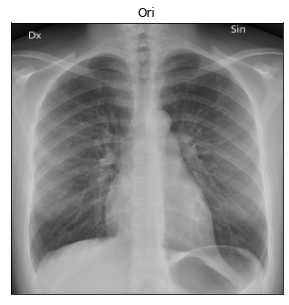

In [17]:
# visualization
image, ori = dataset[2]

print('image name')
print(dataset.images[2])
print()

print('image shape')
print(ori.shape)


# visual data
visualize(
    ori=ori,
)

convert image to tensor
start fiting image to network
get output
reconstructing error is 45.7337646484375


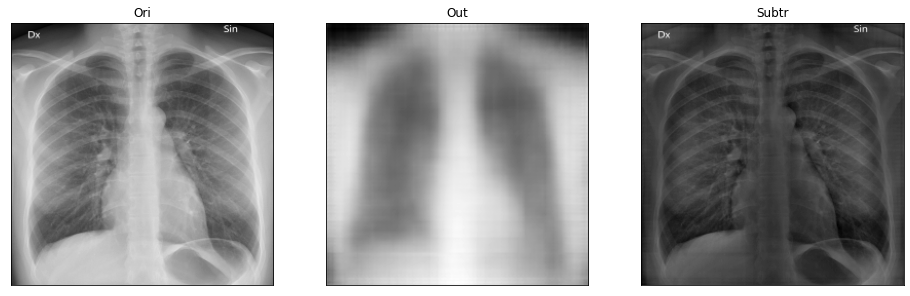

In [18]:
print('convert image to tensor')
x_in = torch.tensor(image).unsqueeze(0).to(DEVICE)

print('start fiting image to network')
with torch.no_grad():
    out = model(x_in)

print('get output')
x_out = out[0].cpu()


print('reconstructing error is {}'.format(np.sum(image.squeeze() - x_out.numpy().squeeze())))

# visual data
visualize(
    ori=image.squeeze(),
    out=x_out.numpy().squeeze(),
    
    subtr = image.squeeze() - x_out.numpy().squeeze(),
)

#### ap/pa

image name
input/ap3.jpeg

image shape
(256, 256, 3)


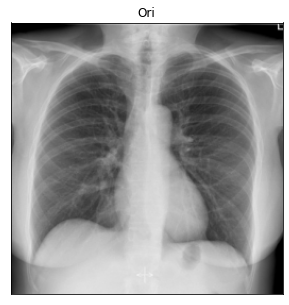

In [15]:
# visualization
image, ori = dataset[1]

print('image name')
print(dataset.images[1])
print()

print('image shape')
print(ori.shape)


# visual data
visualize(
    ori=ori,
)

convert image to tensor
start fiting image to network
get output
reconstructing error is -22.443105697631836


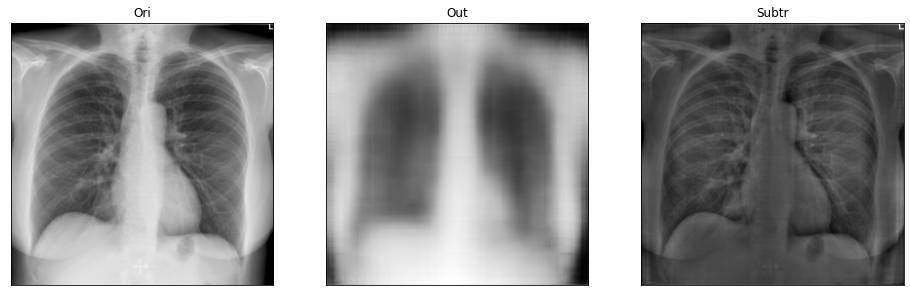

In [16]:
print('convert image to tensor')
x_in = torch.tensor(image).unsqueeze(0).to(DEVICE)

print('start fiting image to network')
with torch.no_grad():
    out = model(x_in)

print('get output')
x_out = out[0].cpu()


print('reconstructing error is {}'.format(np.sum(image.squeeze() - x_out.numpy().squeeze())))

# visual data
visualize(
    ori=image.squeeze(),
    out=x_out.numpy().squeeze(),
    
    subtr = image.squeeze() - x_out.numpy().squeeze(),
)

#### lateral

image name
input/lateral3.jpg

image shape
(256, 256, 3)


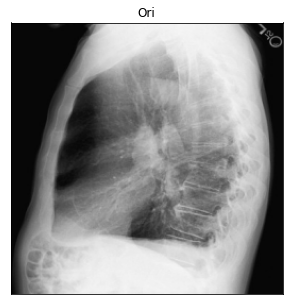

In [20]:
# visualization
image, ori = dataset[4]

print('image name')
print(dataset.images[4])
print()

print('image shape')
print(ori.shape)


# visual data
visualize(
    ori=ori,
)

convert image to tensor
start fiting image to network
get output
reconstructing error is 1515.560791015625


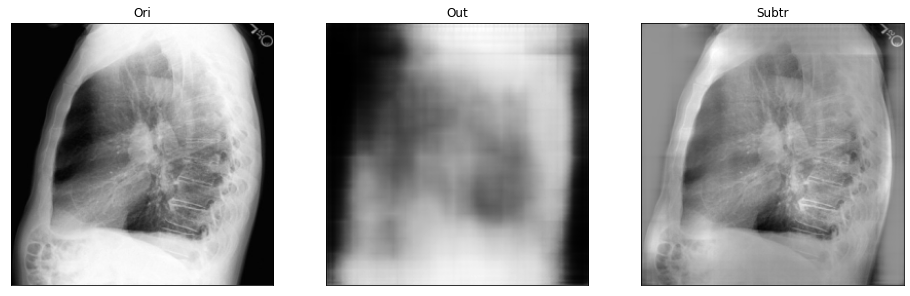

In [21]:
print('convert image to tensor')
x_in = torch.tensor(image).unsqueeze(0).to(DEVICE)

print('start fiting image to network')
with torch.no_grad():
    out = model(x_in)

print('get output')
x_out = out[0].cpu()


print('reconstructing error is {}'.format(np.sum(image.squeeze() - x_out.numpy().squeeze())))

# visual data
visualize(
    ori=image.squeeze(),
    out=x_out.numpy().squeeze(),
    
    subtr = image.squeeze() - x_out.numpy().squeeze(),
)